# Component Modularity Analysis

This notebook computes **modularity** for graph components and creates comprehensive visualizations.

## What is Modularity?

Modularity measures how well a network divides into communities (sub-groups):
- **Range:** -0.5 to 1.0 (typically 0.3-0.7)
- **High (>0.5):** Strong community structure
- **Low (<0.3):** Homogeneous, no clear divisions
- **Zero:** No better than random

## Quick Start
1. Set `FILEPATH` below
2. Run all cells
3. View 7 visualization plots

## Configuration

In [1]:
# Set your dataset path
FILEPATH = "train.txt"  # ← CHANGE THIS

# Number of components to analyze
MAX_COMPONENTS = 50

## Import Libraries

In [3]:
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

try:
    import networkx as nx
    print("✓ NetworkX available")
except ImportError:
    print("❌ Please install: pip install networkx")

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

print("✓ Libraries imported")

✓ NetworkX available
✓ Libraries imported


## Load Graph Data

In [4]:
def load_graph(filepath):
    """Load graph data"""
    edges = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                parts = line.split()
                if len(parts) >= 3:
                    source = parts[0]
                    relation = parts[1]
                    target = parts[2]
                    edges.append((source, relation, target))
    
    return edges

edges = load_graph(FILEPATH)
print(f"✓ Loaded {len(edges):,} edges")

✓ Loaded 13,821 edges


## Find Components

In [5]:
def find_weakly_connected_components(edges):
    """Find weakly connected components"""
    undirected_graph = defaultdict(set)
    all_entities = set()
    
    for source, relation, target in edges:
        undirected_graph[source].add(target)
        undirected_graph[target].add(source)
        all_entities.add(source)
        all_entities.add(target)
    
    visited = set()
    components = []
    
    for start_entity in all_entities:
        if start_entity in visited:
            continue
        
        component = set()
        queue = deque([start_entity])
        
        while queue:
            entity = queue.popleft()
            if entity in visited:
                continue
            visited.add(entity)
            component.add(entity)
            
            for neighbor in undirected_graph[entity]:
                if neighbor not in visited:
                    queue.append(neighbor)
        
        components.append(component)
    
    return sorted(components, key=len, reverse=True)

components = find_weakly_connected_components(edges)
print(f"✓ Found {len(components):,} components")
print(f"  Largest: {len(components[0]):,} nodes")
print(f"  Smallest: {len(components[-1]):,} nodes")

✓ Found 50 components
  Largest: 27 nodes
  Smallest: 26 nodes


## Compute Modularity for Each Component

This uses the Louvain algorithm for community detection and computes modularity.

In [15]:
def compute_component_modularity(component, edges):
    """Compute modularity and other metrics for a component"""
    # Create undirected graph
    G = nx.Graph()
    
    for source, relation, target in edges:
        if source in component and target in component:
            G.add_edge(source, target)
    
    # Need at least 2 nodes
    if G.number_of_nodes() < 2:
        return {
            'modularity': 0.0,
            'num_communities': 1,
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': 0.0,
            'avg_clustering': 0.0
        }
    
    try:
        # Detect communities
        communities = nx.community.greedy_modularity_communities(G)
        
        # Compute modularity
        modularity = nx.community.modularity(G, communities)
        
        # Additional metrics
        density = nx.density(G)
        avg_clustering = nx.average_clustering(G)
        
        return {
            'modularity': modularity,
            'num_communities': len(communities),
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': density,
            'avg_clustering': avg_clustering
        }
    except:
        return {
            'modularity': 0.0,
            'num_communities': 1,
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G) if G.number_of_nodes() > 0 else 0.0,
            'avg_clustering': 0.0
        }

# Analyze components
print(f"Analyzing top {MAX_COMPONENTS} components...\n")

results = []
components_to_analyze = min(MAX_COMPONENTS, len(components))

for idx, component in enumerate(components[:components_to_analyze], 1):
    print(f"Processing component {idx}/{components_to_analyze}...", end='\r')
    
    stats = compute_component_modularity(component, edges)
    stats['component_id'] = idx
    stats['component_rank'] = idx
    
    results.append(stats)

df = pd.DataFrame(results)

print(f"\n✓ Analyzed {components_to_analyze} components")
print(f"\nFirst 10 results:")
display(df.head(40))

Analyzing top 50 components...

Processing component 50/50...
✓ Analyzed 50 components

First 10 results:


,modularity,num_communities,nodes,edges,density,avg_clustering,component_id,component_rank
0,0.226877,2,27,139,0.396011,0.768162,1,1
1,0.194275,4,27,128,0.364672,0.797604,2,2
2,0.179094,3,27,157,0.447293,0.811722,3,3
3,0.218750,2,27,140,0.398860,0.721739,4,4
4,0.095235,2,27,188,0.535613,0.795900,5,5
5,0.178115,3,27,153,0.435897,0.791646,6,6
6,0.359687,2,27,120,0.341880,0.821181,7,7
7,0.110061,3,27,167,0.475783,0.844579,8,8
8,0.254944,3,27,125,0.356125,0.786778,9,9
9,0.229036,2,27,157,0.447293,0.798736,10,10


## Summary Statistics

In [7]:
print("="*80)
print("MODULARITY SUMMARY STATISTICS")
print("="*80)

print(f"\nComponents analyzed: {len(df)}")
print(f"\nModularity Statistics:")
print(f"  Mean:     {df['modularity'].mean():.4f}")
print(f"  Median:   {df['modularity'].median():.4f}")
print(f"  Std Dev:  {df['modularity'].std():.4f}")
print(f"  Min:      {df['modularity'].min():.4f}")
print(f"  Max:      {df['modularity'].max():.4f}")

print(f"\nTop 10 Components by Modularity:")
print("-" * 80)
top_10 = df.nlargest(10, 'modularity')
for _, row in top_10.iterrows():
    print(f"  Component {int(row['component_id']):3d}: "
          f"Modularity={row['modularity']:.4f}, "
          f"Nodes={int(row['nodes']):4d}, "
          f"Communities={int(row['num_communities']):2d}")

MODULARITY SUMMARY STATISTICS

Components analyzed: 50

Modularity Statistics:
  Mean:     0.1800
  Median:   0.1760
  Std Dev:  0.0806
  Min:      0.0394
  Max:      0.3876

Top 10 Components by Modularity:
--------------------------------------------------------------------------------
  Component  37: Modularity=0.3876, Nodes=  26, Communities= 3
  Component  43: Modularity=0.3720, Nodes=  26, Communities= 2
  Component   7: Modularity=0.3597, Nodes=  27, Communities= 2
  Component  22: Modularity=0.3118, Nodes=  26, Communities= 3
  Component  39: Modularity=0.2857, Nodes=  26, Communities= 2
  Component  34: Modularity=0.2821, Nodes=  26, Communities= 3
  Component  16: Modularity=0.2714, Nodes=  27, Communities= 3
  Component  19: Modularity=0.2644, Nodes=  26, Communities= 2
  Component   9: Modularity=0.2549, Nodes=  27, Communities= 3
  Component  38: Modularity=0.2392, Nodes=  26, Communities= 3


## Save Results to CSV

In [ ]:
df.to_csv('component_modularity_results.csv', index=False)
print("✓ Saved: component_modularity_results.csv")

# VISUALIZATIONS

Now let's create 7 comprehensive visualizations!

## Plot 1: Modularity by Component (Bar Chart)

✓ Saved: modularity_by_component.png


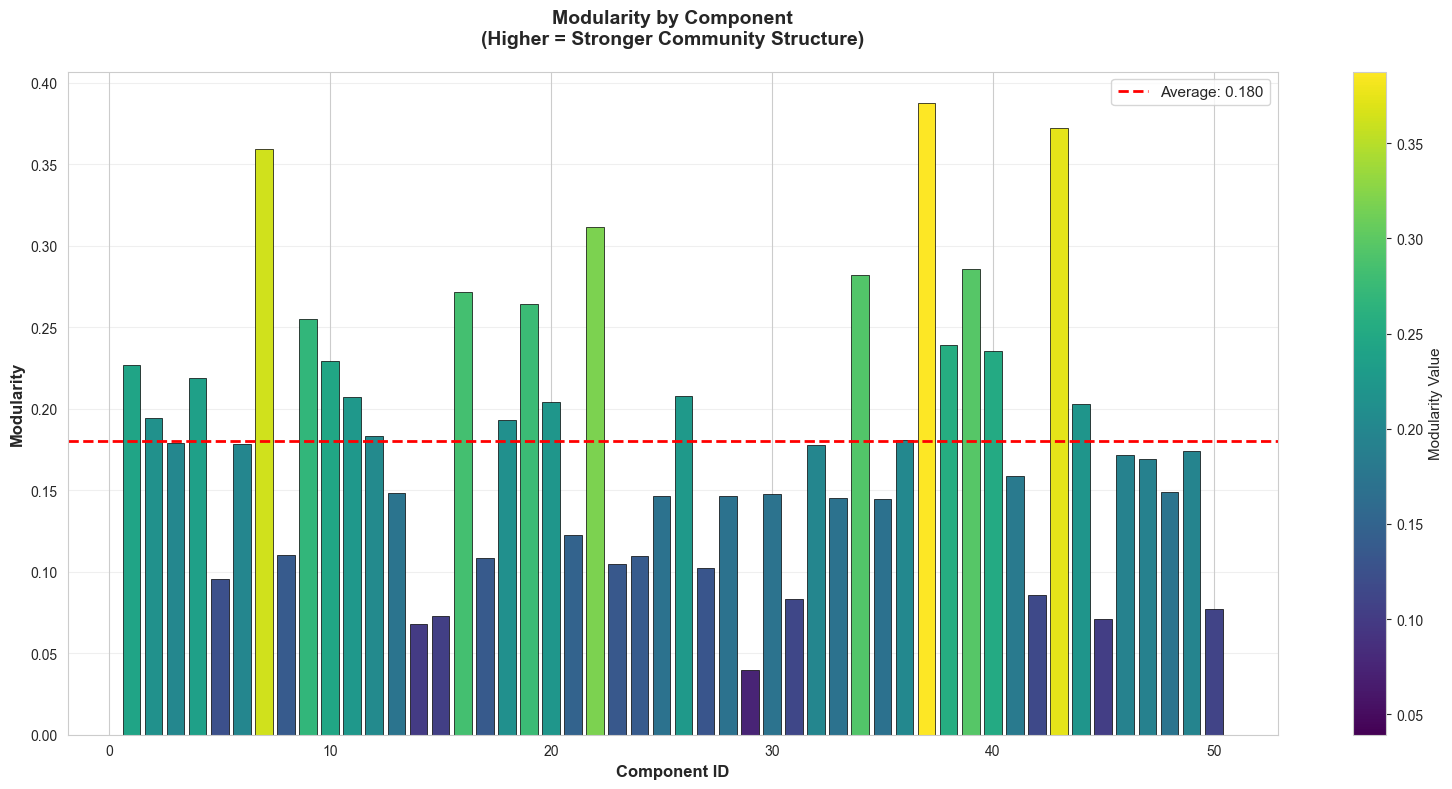

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))

colors = plt.cm.viridis(df['modularity'] / df['modularity'].max())
bars = ax.bar(df['component_id'], df['modularity'], color=colors, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Component ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Modularity', fontsize=12, fontweight='bold')
ax.set_title('Modularity by Component\n(Higher = Stronger Community Structure)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                           norm=plt.Normalize(vmin=df['modularity'].min(), 
                                             vmax=df['modularity'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Modularity Value', fontsize=11)

# Add average line
avg_modularity = df['modularity'].mean()
ax.axhline(y=avg_modularity, color='red', linestyle='--', linewidth=2, 
           label=f'Average: {avg_modularity:.3f}')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('modularity_by_component.png', dpi=200, bbox_inches='tight')
print("✓ Saved: modularity_by_component.png")
plt.show()

## Plot 2: Distribution of Modularity (Histogram + KDE)

AttributeError: 'dict' object has no attribute 'gaussian_kde'

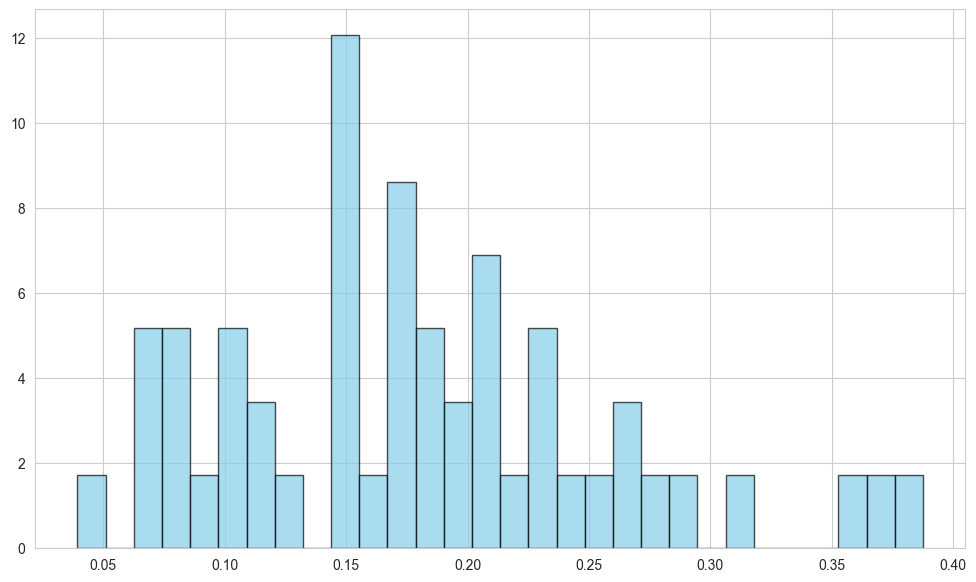

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.hist(df['modularity'], bins=30, color='skyblue', edgecolor='black', 
        alpha=0.7, density=True, label='Distribution')

# KDE
kde = stats.gaussian_kde(df['modularity'])
x_range = np.linspace(df['modularity'].min(), df['modularity'].max(), 100)
ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Density Curve')

# Mean and median
mean_val = df['modularity'].mean()
median_val = df['modularity'].median()

ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_val:.3f}')
ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, 
           label=f'Median: {median_val:.3f}')

ax.set_xlabel('Modularity', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Modularity Across Components', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modularity_distribution.png', dpi=200, bbox_inches='tight')
print("✓ Saved: modularity_distribution.png")
plt.show()

## Plot 3: Modularity vs Component Size (Scatter)

✓ Saved: modularity_vs_size.png


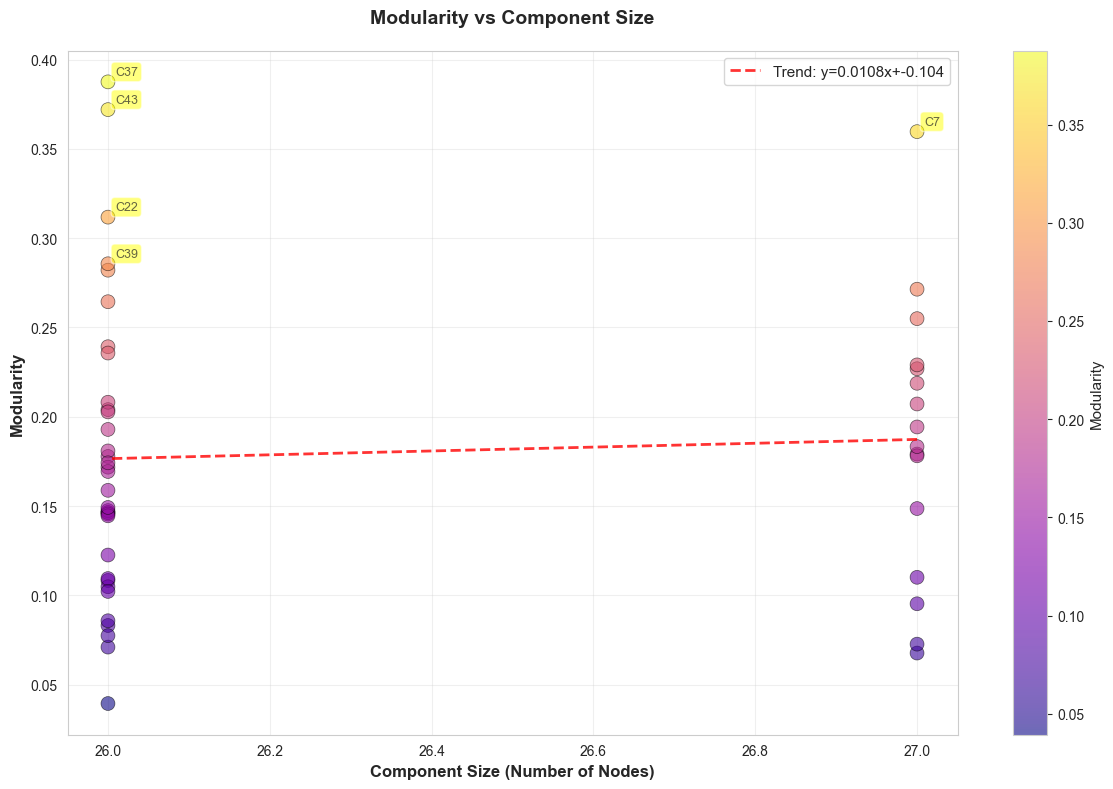

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df['nodes'], df['modularity'], 
                    s=100, c=df['modularity'], cmap='plasma',
                    alpha=0.6, edgecolor='black', linewidth=0.5)

# Trend line
z = np.polyfit(df['nodes'], df['modularity'], 1)
p = np.poly1d(z)
ax.plot(df['nodes'], p(df['nodes']), "r--", alpha=0.8, linewidth=2, 
        label=f'Trend: y={z[0]:.4f}x+{z[1]:.3f}')

ax.set_xlabel('Component Size (Number of Nodes)', fontsize=12, fontweight='bold')
ax.set_ylabel('Modularity', fontsize=12, fontweight='bold')
ax.set_title('Modularity vs Component Size', fontsize=14, fontweight='bold', pad=20)
ax.grid(alpha=0.3)
ax.legend(fontsize=11)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Modularity', fontsize=11)

# Annotate top 5
top_5 = df.nlargest(5, 'modularity')
for _, row in top_5.iterrows():
    ax.annotate(f"C{int(row['component_id'])}",
               (row['nodes'], row['modularity']),
               xytext=(5, 5), textcoords='offset points',
               fontsize=9, alpha=0.7,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig('modularity_vs_size.png', dpi=200, bbox_inches='tight')
print("✓ Saved: modularity_vs_size.png")
plt.show()

## Plot 4: Multiple Metrics Comparison (Heatmap)

✓ Saved: metrics_heatmap.png


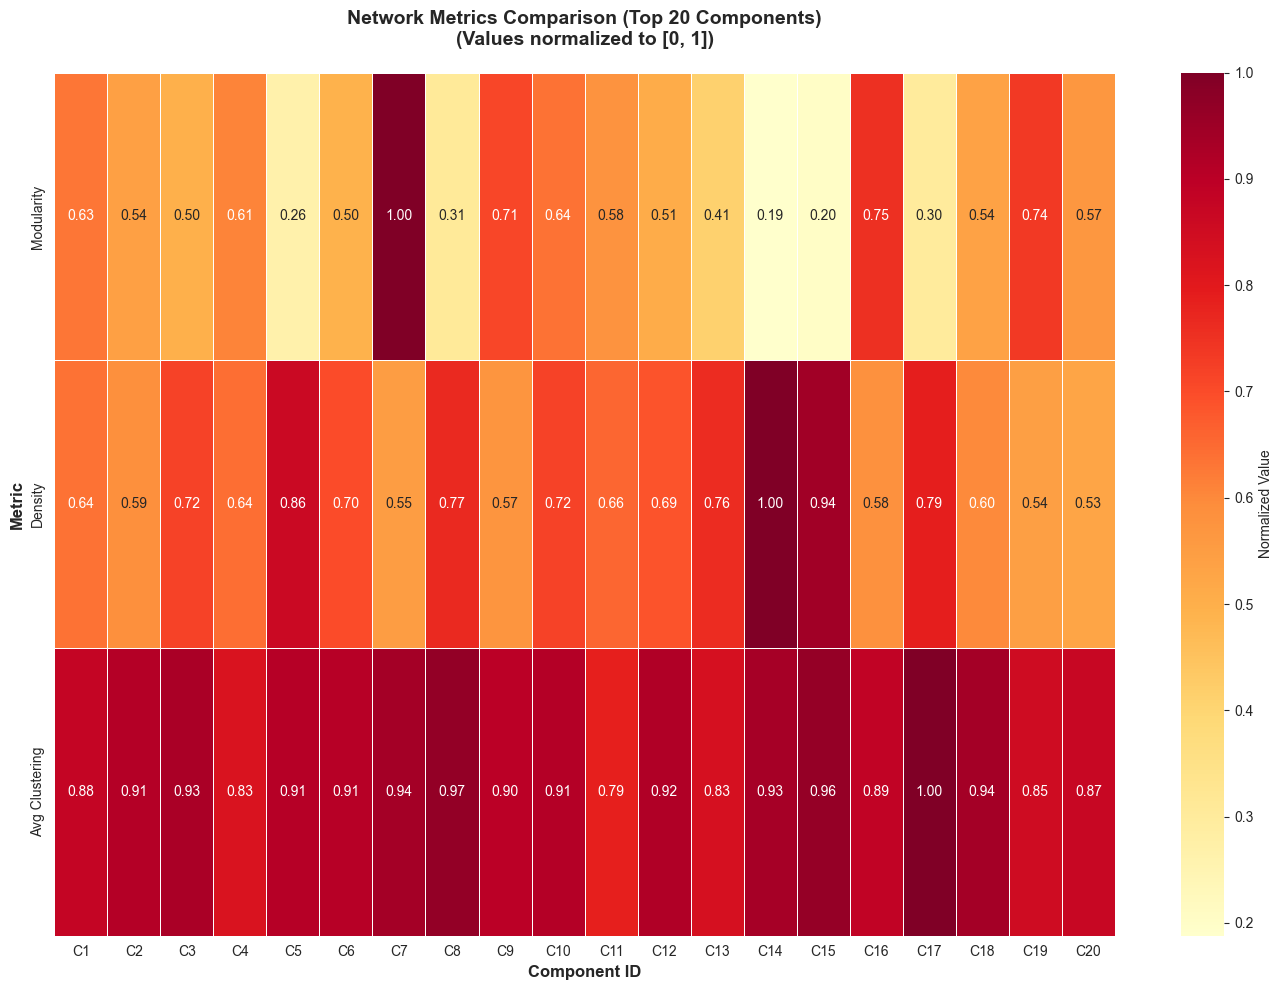

In [11]:
fig, ax = plt.subplots(figsize=(14, 10))

# Top 20 components
df_top = df.head(20).copy()

# Normalize metrics
metrics = ['modularity', 'density', 'avg_clustering']
df_normalized = df_top[metrics].copy()

for col in metrics:
    max_val = df_normalized[col].max()
    if max_val > 0:
        df_normalized[col] = df_normalized[col] / max_val

# Heatmap
sns.heatmap(df_normalized.T, 
            annot=True, fmt='.2f', 
            cmap='YlOrRd', 
            xticklabels=[f"C{int(x)}" for x in df_top['component_id']],
            yticklabels=['Modularity', 'Density', 'Avg Clustering'],
            cbar_kws={'label': 'Normalized Value'},
            linewidths=0.5,
            ax=ax)

ax.set_title('Network Metrics Comparison (Top 20 Components)\n(Values normalized to [0, 1])', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Component ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_heatmap.png', dpi=200, bbox_inches='tight')
print("✓ Saved: metrics_heatmap.png")
plt.show()

## Plot 5: Box Plot by Size Categories

✓ Saved: modularity_by_size_category.png


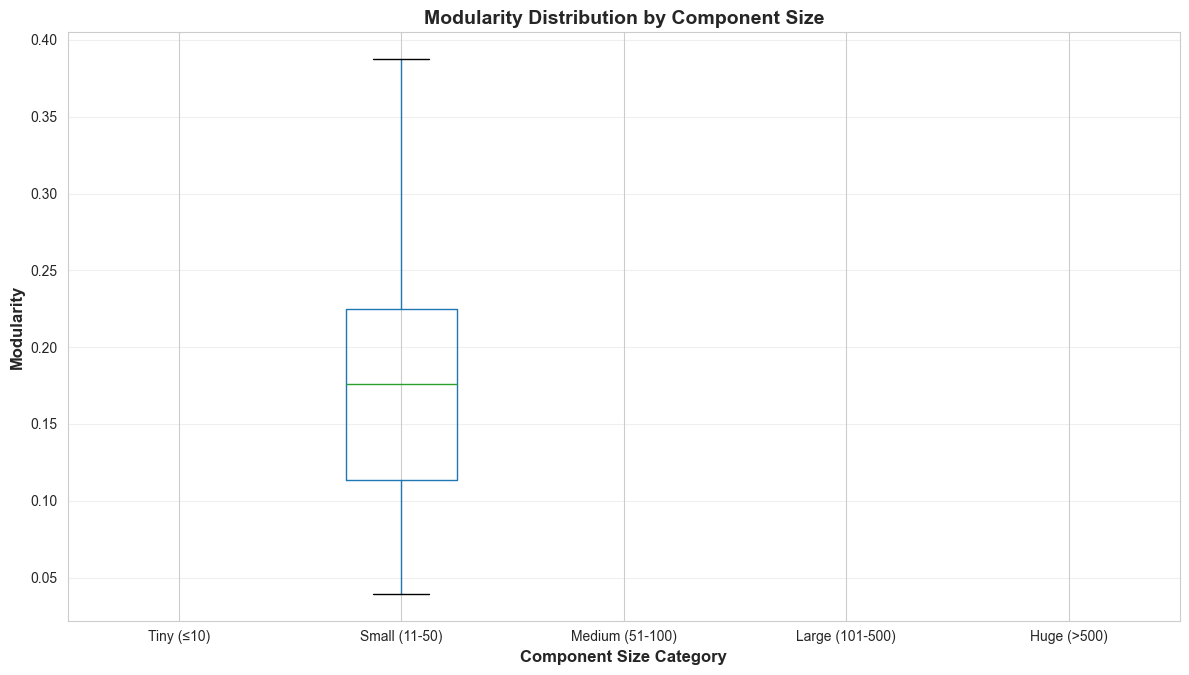

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))

# Categorize by size
df['size_category'] = pd.cut(df['nodes'], 
                              bins=[0, 10, 50, 100, 500, float('inf')],
                              labels=['Tiny (≤10)', 'Small (11-50)', 
                                     'Medium (51-100)', 'Large (101-500)', 
                                     'Huge (>500)'])

# Box plot
df.boxplot(column='modularity', by='size_category', ax=ax)

ax.set_xlabel('Component Size Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Modularity', fontsize=12, fontweight='bold')
ax.set_title('Modularity Distribution by Component Size', 
             fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('modularity_by_size_category.png', dpi=200, bbox_inches='tight')
print("✓ Saved: modularity_by_size_category.png")
plt.show()

## Plot 6: Communities vs Nodes (Scatter)

✓ Saved: communities_vs_nodes.png


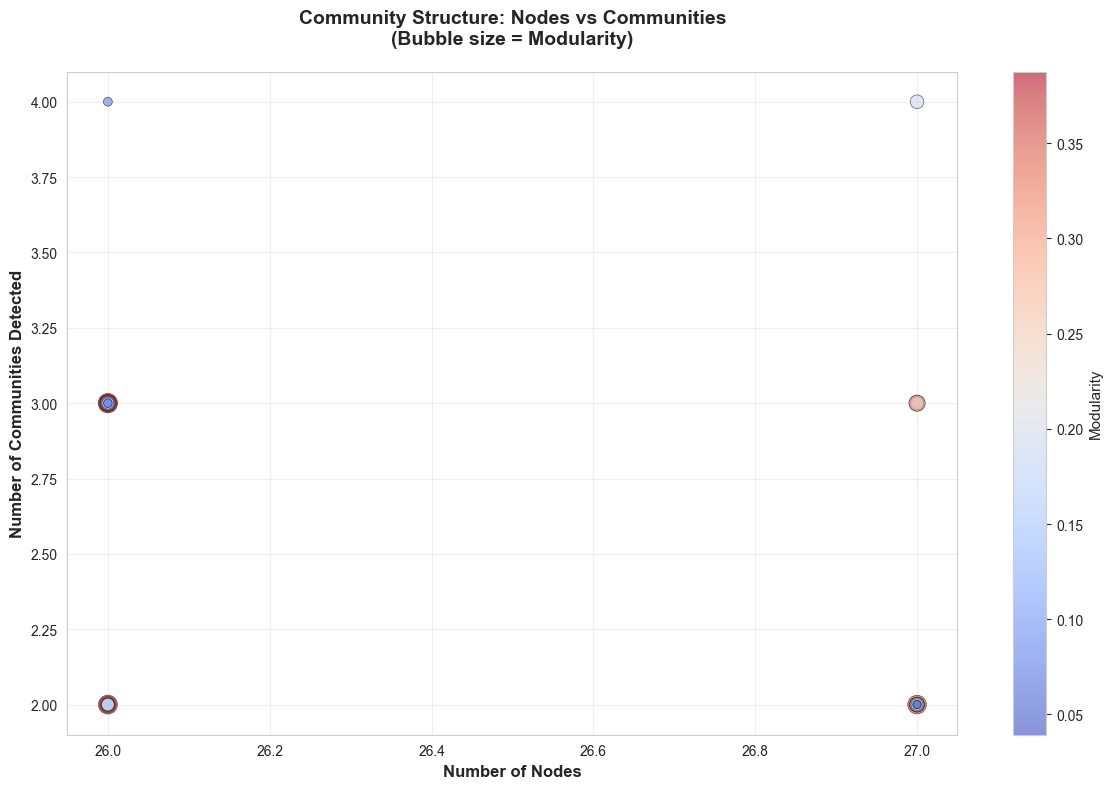

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df['nodes'], df['num_communities'], 
                    s=df['modularity']*500,  # Size by modularity
                    c=df['modularity'], cmap='coolwarm',
                    alpha=0.6, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Number of Nodes', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Communities Detected', fontsize=12, fontweight='bold')
ax.set_title('Community Structure: Nodes vs Communities\n(Bubble size = Modularity)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Modularity', fontsize=11)

plt.tight_layout()
plt.savefig('communities_vs_nodes.png', dpi=200, bbox_inches='tight')
print("✓ Saved: communities_vs_nodes.png")
plt.show()

## Plot 7: Top 10 Components Comparison

✓ Saved: top10_comparison.png


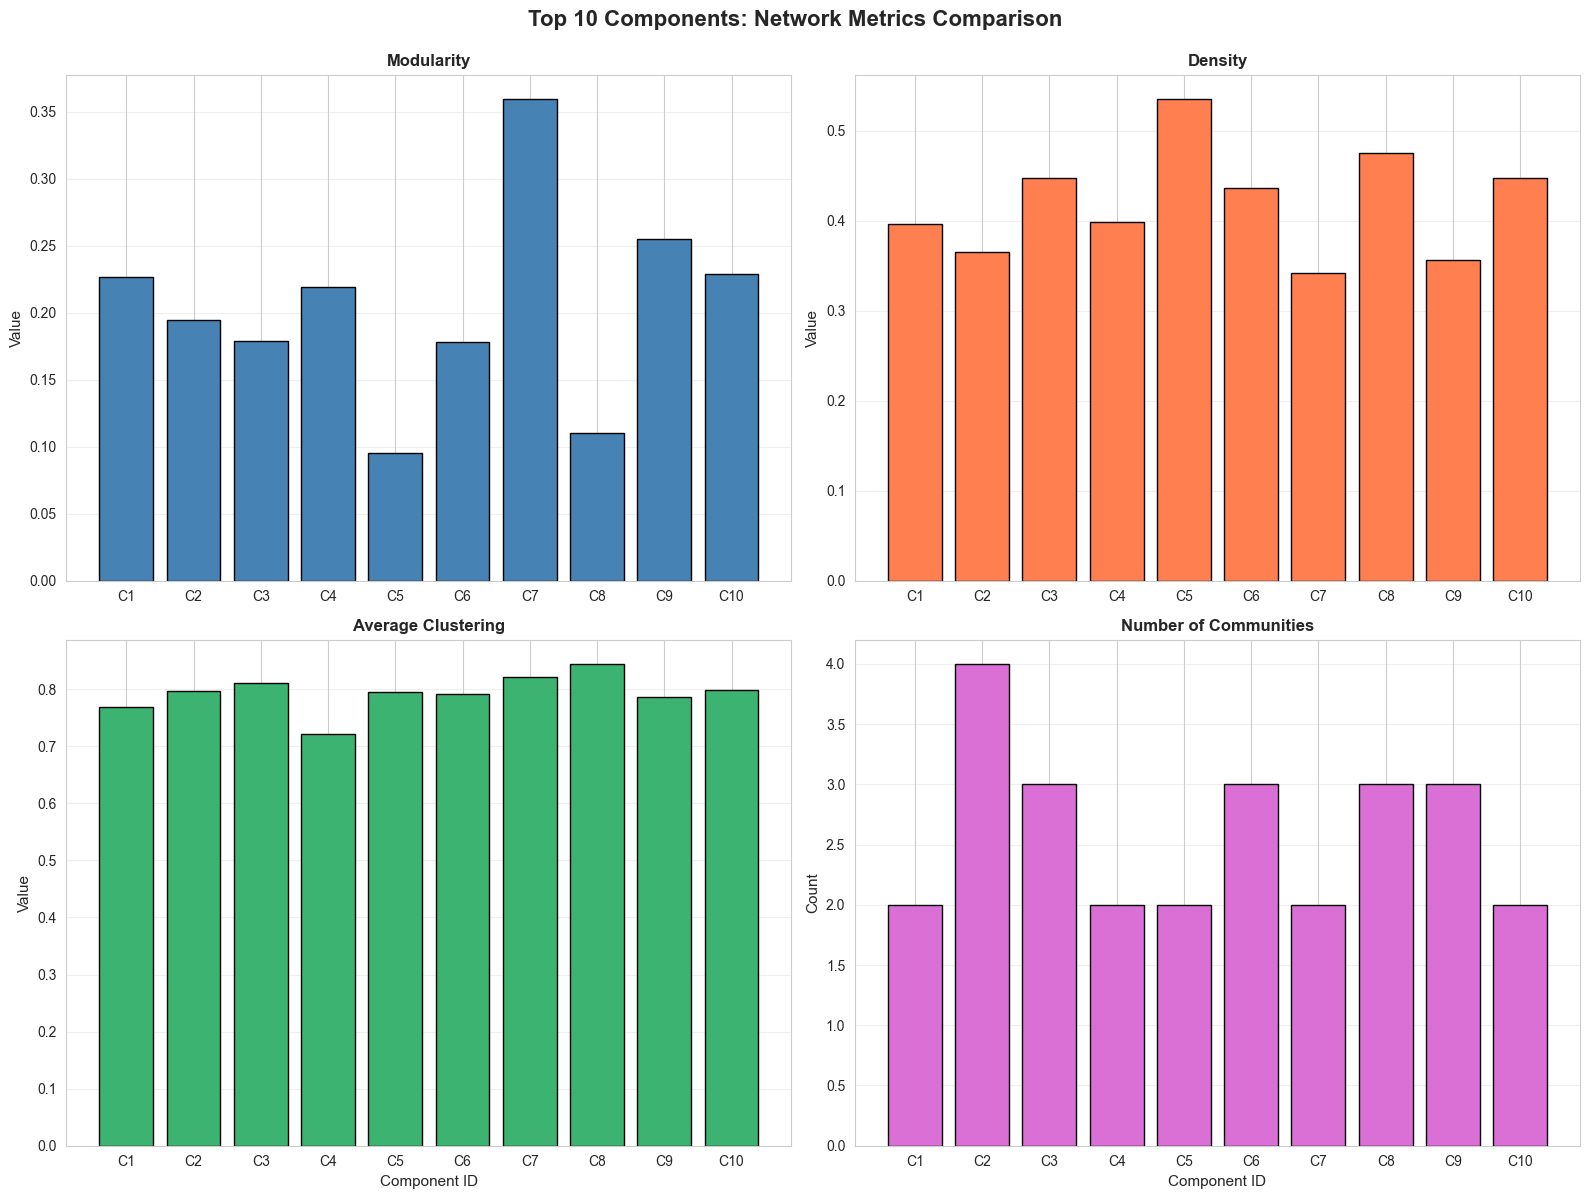

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

top_10 = df.head(10)
x_labels = [f"C{int(x)}" for x in top_10['component_id']]

# Modularity
axes[0, 0].bar(x_labels, top_10['modularity'], color='steelblue', edgecolor='black')
axes[0, 0].set_title('Modularity', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Value', fontsize=11)
axes[0, 0].grid(axis='y', alpha=0.3)

# Density
axes[0, 1].bar(x_labels, top_10['density'], color='coral', edgecolor='black')
axes[0, 1].set_title('Density', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Value', fontsize=11)
axes[0, 1].grid(axis='y', alpha=0.3)

# Clustering
axes[1, 0].bar(x_labels, top_10['avg_clustering'], color='mediumseagreen', edgecolor='black')
axes[1, 0].set_title('Average Clustering', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Component ID', fontsize=11)
axes[1, 0].set_ylabel('Value', fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)

# Communities
axes[1, 1].bar(x_labels, top_10['num_communities'], color='orchid', edgecolor='black')
axes[1, 1].set_title('Number of Communities', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Component ID', fontsize=11)
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].grid(axis='y', alpha=0.3)

fig.suptitle('Top 10 Components: Network Metrics Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('top10_comparison.png', dpi=200, bbox_inches='tight')
print("✓ Saved: top10_comparison.png")
plt.show()

## Summary

✅ All analysis complete!

**Generated files:**
- component_modularity_results.csv
- modularity_by_component.png
- modularity_distribution.png
- modularity_vs_size.png
- metrics_heatmap.png
- modularity_by_size_category.png
- communities_vs_nodes.png
- top10_comparison.png